# Analysis and Visualization of Complex Agro-Environmental Data
---
### Exercise #5 - correction

In [22]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns # For plotting
import matplotlib.pyplot as plt # For showing plots
import scipy.stats as sts
import scikit_posthocs as sp
import statsmodels.stats as stm
from statsmodels.graphics.gofplots import qqplot

In [23]:
df = pd.read_csv('EFIplus_medit.zip',compression='zip', sep=";")

In [24]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df.drop(df.iloc[:,5:15], axis=1, inplace=True)

# let's rename some columns so that they make sense
df.rename(columns={'Sum of Run1_number_all':'Total_fish_individuals'}, inplace=True) # inplace="True" means that df will be updated

# for sake of consistency, let's also make all column labels of type string
df.columns = list(map(str, df.columns))

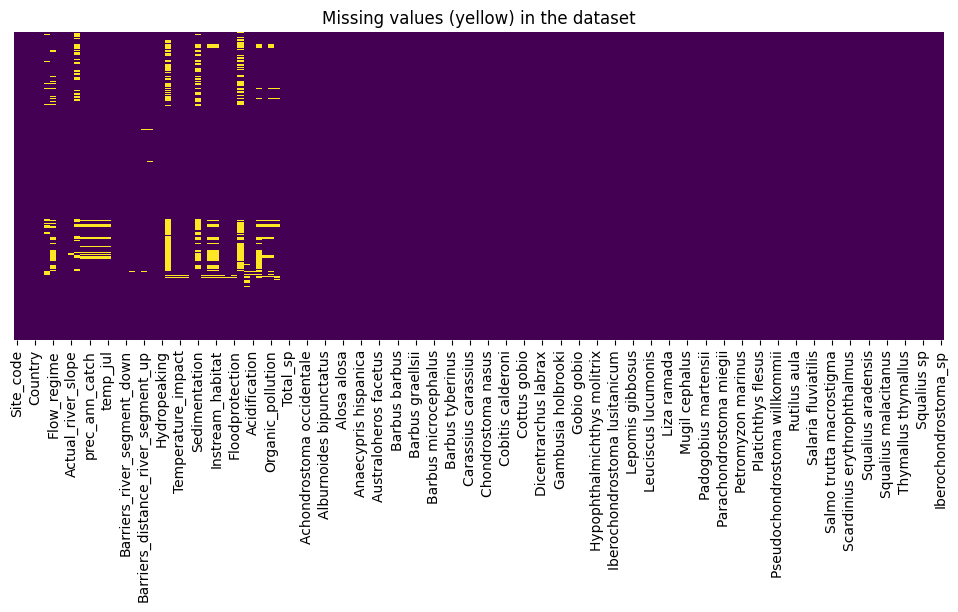

In [25]:
# a good way of detecting missing values in the dataset
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing values (yellow) in the dataset');

##### Exercise 5.1

In [26]:
# produce contingency table of Country and Samo trutta fario.
cdf = pd.crosstab(index=df['Country'], columns=df['Salmo trutta fario'])
print(cdf)

Salmo trutta fario     0     1
Country                       
France                13    59
Italy                109    76
Portugal             615   252
Spain               1239  2648


In [27]:
# Chi-square test of independency
stat, p, df, expected = sts.chi2_contingency(cdf)
print('df=%d' % df)
print('expected values:')
print(expected)
# interpret test-statistic
prob=0.95
critical = sts.chi2.ppf(prob, df)
print('critical=%.3f, stat=%.3f' % (critical, stat))
if abs(stat) >= critical:
 print('reject H0 that variables are independent')
else:
 print('fail to reject H0 that variables are independent')
# interpret p-value
alpha = 0.05
print('significance=%.2f, p=%.3f' % (alpha, p))
if p <= alpha:
 print('reject H0 that variables are independent')
else:
 print('fail to reject H0 that variables are independent')

df=3
expected values:
[[  28.39193774   43.60806226]
 [  72.95150669  112.04849331]
 [ 341.88625025  525.11374975]
 [1532.77030533 2354.22969467]]
critical=7.815, stat=496.372
reject H0 that variables are independent
significance=0.05, p=0.000
reject H0 that variables are independent


##### Exercise 5.2

In [28]:
sns.boxplot(data=df,x='Salmo trutta fario',y='Actual_river_slope')

AttributeError: 'int' object has no attribute 'get'

In [ ]:
# Run Mann-Whitney U test - t test would be inadequate as actual_river_slope is very far from normality and has many outliers (see exercise 4)
df2 = df.dropna() # need to remove missing data (will not run with missing data)

sample1 = df2[df2['Salmo trutta fario']==0]['Actual_river_slope']
sample2 = df2[df2['Salmo trutta fario']==1]['Actual_river_slope']

Meds1 = sample1.median()
Meds2 = sample2.median()

stat, p = sts.mannwhitneyu(sample1, sample2, alternative='two-sided')
print('stat=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p <= alpha:
 print('reject H0 that median values are equal')
else:
 print('fail to reject H0')

print('Median of sample 1 = %.2f' % Meds1)
print('Median of sample 2 = %.2f' % Meds2)

AttributeError: 'int' object has no attribute 'dropna'

##### Exercise 5.3

In [ ]:
catchment_count = pd.crosstab(index = df['Catchment_name'], columns='count')
catchment_count.sort_values(by=['count'], ascending=False)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

dfsub = df2[(df2['Catchment_name']=='Ebro') | 
    (df2['Catchment_name']=='Galiza-Norte') |
    (df2['Catchment_name']=='Minho') |
    (df2['Catchment_name']=='Tejo')
    ]

In [ ]:
sns.histplot(df['Actual_river_slope'])

In [ ]:
from statsmodels.graphics.gofplots import qqplot

qqplot(pd.Series(df2['Elevation_mean_catch']), line='s')
plt.show()

In [ ]:
# Although the distribution of the mean elevation is right skewed and seems to depart from normality we will nevertheless try to run ANOVA. 

mod = ols('Elevation_mean_catch ~ Catchment_name',
                data=dfsub).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2) # typ is the type of anova type to perform ('I','II' or 'III' = 1,2,3)
print(aov_table) # provides the usual ANOVA table

alpha=0.05
p=aov_table['PR(>F)'][0]

if p <= alpha:
 print('reject H0 that mean elevation values are equal among catchments')
else:
 print('fail to reject H0 that mean elevation values are equal among catchments')

# compute mean elevation for eacch catchment
dfsub[['Elevation_mean_catch','Catchment_name']].groupby('Catchment_name').mean()


In [ ]:
# Multiple comparisons - perform Tukey's test 
tukey = stm.multicomp.pairwise_tukeyhsd(endog=dfsub['Elevation_mean_catch'],
                          groups=dfsub['Catchment_name'],
                          alpha=0.05)
#display results
print(tukey)

In [ ]:
sns.boxplot(data=dfsub, x='Catchment_name', y='Actual_river_slope')

In [ ]:
# Run non-parametric equivalent to one-way ANOVA - Kruskal-Walis test
sample1 = df2[(df2['Catchment_name']=='Ebro')]['Elevation_mean_catch']
sample2 = df2[(df2['Catchment_name']=='Galiza-Norte')]['Elevation_mean_catch']
sample3 = df2[(df2['Catchment_name']=='Minho')]['Elevation_mean_catch']
sample4 = df2[(df2['Catchment_name']=='Tejo')]['Elevation_mean_catch']

stat, p = sts.kruskal(sample1, sample2, sample3, sample4)
print('F-statistics=%.3f, p=%.6f' % (stat, p))

alpha=0.05

if p <= alpha:
 print('reject H0 that median elevation values are equal among catchments')
else:
 print('fail to reject H0 that median elevation values are equal among catchments')

# Compute median values of Mean elevation for each catchment
dfsub[['Elevation_mean_catch','Catchment_name']].groupby('Catchment_name').median()

In [ ]:
# Non-parametric multiple comparisons: Dunn's test
# need to produce a list with samples
list_sample = [sample1, sample2, sample2, sample4]
sp.posthoc_dunn(list_sample, p_adjust = 'bonferroni') # the correction for multiple comparisons is based on the bonferroni's correction.
# the output is a matrix of p-values for each pair of groups.

##### Exercise 5.4

Potential problems in the data used for hypothesis testing is that categories are highly unbalanced (very different number of samples for each category - see below). Another potential problem is the lak of independency among sampling sites. For example when we tested the effect of Actual_river_slope in the presence of Salmo trutta fario, we did not take into account that observations within each catchment might not be totally independent.



In [ ]:
print(dfsub['Catchment_name'].value_counts())
print(df['Salmo trutta fario'].value_counts())